In [1]:
pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
IMAGE_SIZE_1=224
IMAGE_SIZE_2=224
BATCH_SIZE=32
EPOCHS=50
CHANNELS = 3
dataset_path = "/content/drive/MyDrive/PharmaScope"

In [4]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE_1, IMAGE_SIZE_2),
    batch_size=BATCH_SIZE
)

Found 3495 files belonging to 27 classes.


In [5]:
class_names = dataset.class_names
class_names

['Albendazole',
 'Amoxicillin',
 'Beclovent dry powder capsule',
 'Bisacodyl',
 'Cephalexin',
 'Cetirizine',
 'Cypro',
 'Dexamethasone',
 'Diclofenac',
 'Domperidone',
 'Famotidine',
 'Flutihale dry powder capsule',
 'Folic acid',
 'Iprahale dry powder capsule',
 'Losatan',
 'Metformin',
 'Nifitepin',
 'Not Medicine',
 'Omeprazole',
 'Paracetamol',
 'Piriton',
 'Propranolol',
 'Salbutamol',
 'Salhale dry powder capsule',
 'Vitamin C',
 'Vitamin b-complex',
 'gastro resistant tablets']

In [6]:
len(dataset)

110

In [7]:
def get_dataset_partions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size= int(train_split * ds_size)
    val_size= int(val_split * ds_size)

    train_ds= ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partions_tf(dataset)

In [9]:
len(test_ds)

11

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [11]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
vgg16 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS)
)

58889256/58889256 [==============================] - 4s 0us/step


In [14]:
# Freeze the VGG16 layers
for layer in vgg16.layers:
    layer.trainable = False

In [15]:
# Build the model
model = models.Sequential([
    vgg16,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

In [16]:
model.build(input_shape=(None, IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                13851     
                                                                 
Total params: 27574107 (105.19 MB)
Trainable params: 12859419 (49.05 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [18]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
88/88 [==============================] - 471s 3s/step - loss: 6.1055 - accuracy: 0.4117 - val_loss: 0.8584 - val_accuracy: 0.7472
Epoch 2/50
88/88 [==============================] - 9s 105ms/step - loss: 1.3094 - accuracy: 0.6095 - val_loss: 0.5186 - val_accuracy: 0.8466
Epoch 3/50
88/88 [==============================] - 9s 106ms/step - loss: 1.0103 - accuracy: 0.6922 - val_loss: 0.5366 - val_accuracy: 0.8409
Epoch 4/50
88/88 [==============================] - 9s 106ms/step - loss: 0.8622 - accuracy: 0.7291 - val_loss: 0.2904 - val_accuracy: 0.9148
Epoch 5/50
88/88 [==============================] - 9s 106ms/step - loss: 0.7532 - accuracy: 0.7625 - val_loss: 0.3573 - val_accuracy: 0.8807
Epoch 6/50
88/88 [==============================] - 9s 107ms/step - loss: 0.7131 - accuracy: 0.7685 - val_loss: 0.2012 - val_accuracy: 0.9290
Epoch 7/50
88/88 [==============================] - 9s 107ms/step - loss: 0.6355 - accuracy: 0.7854 - val_loss: 0.2258 - val_accuracy: 0.9318
Epoch 8

In [20]:
# Evaluate the model
scores = model.evaluate(test_ds)

11/11 [==============================] - 215s 94ms/step - loss: 0.0230 - accuracy: 0.9915


In [21]:
# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

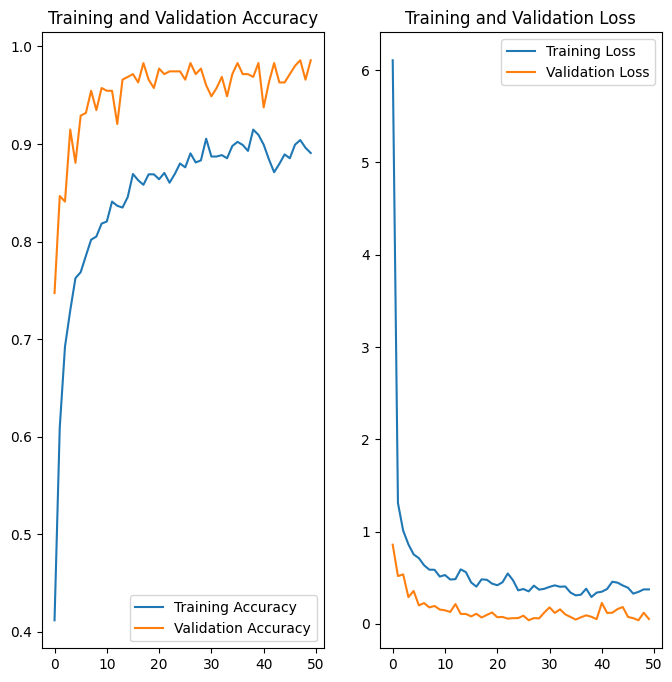

In [22]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


In [23]:
# Function to predict and plot images with actual and predicted labels
def predict_and_plot(model, dataset):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            img_array = tf.expand_dims(images[i].numpy(), 0)
            predictions = model.predict(img_array)
            predicted_class = class_names[np.argmax(predictions[0])]
            actual_class = class_names[labels[i]]
            confidence = round(100 * np.max(predictions[0]), 2)
            plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence:.2f}%")
            plt.axis("off")

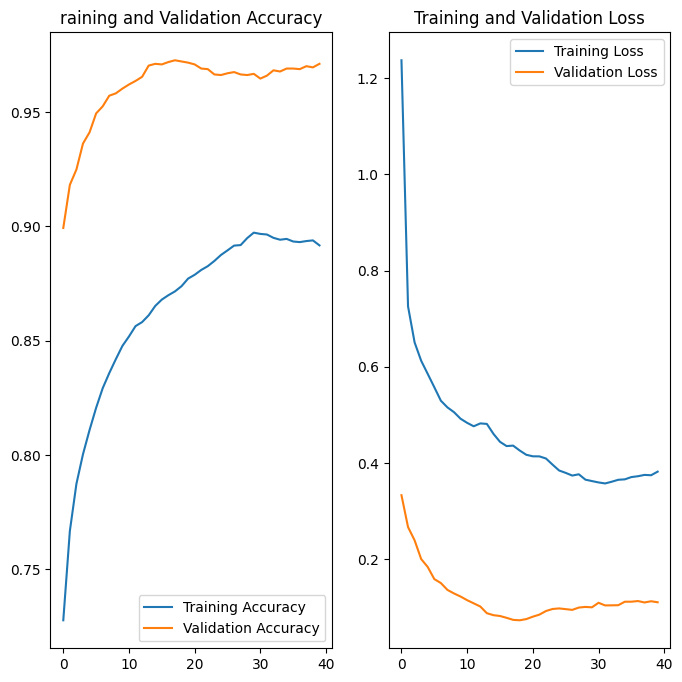

In [24]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
# Smooth the training and validation accuracy and loss
window_size = 11  # Adjust the window size for more or less smoothing
smooth_acc = moving_average(acc, window_size)
smooth_val_acc = moving_average(val_acc, window_size)
smooth_loss = moving_average(loss, window_size)
smooth_val_loss = moving_average(val_loss, window_size)

# Adjust the range to match the smoothed data
smooth_range = range(len(smooth_acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(smooth_range, smooth_acc, label='Training Accuracy')
plt.plot(smooth_range, smooth_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('raining and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(smooth_range, smooth_loss, label='Training Loss')
plt.plot(smooth_range, smooth_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [25]:
# Function to calculate F1 score, precision, and recall
def calculate_metrics(model, dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
    return y_true, y_pred



In [26]:
# Calculate precision, recall, F1 score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
y_true, y_pred = calculate_metrics(model, test_ds)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

1/1 [==============================] - 0s 28ms/step


In [27]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

In [28]:
# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Accuracy:", accuracy)


Precision: 0.9918874574623238
Recall: 0.9914772727272727
F1 Score: 0.9914019121729719
Accuracy: 0.9914772727272727


In [29]:
# Function to calculate F1 score and plot confusion matrix
def calculate_metrics(model, dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

In [30]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 13

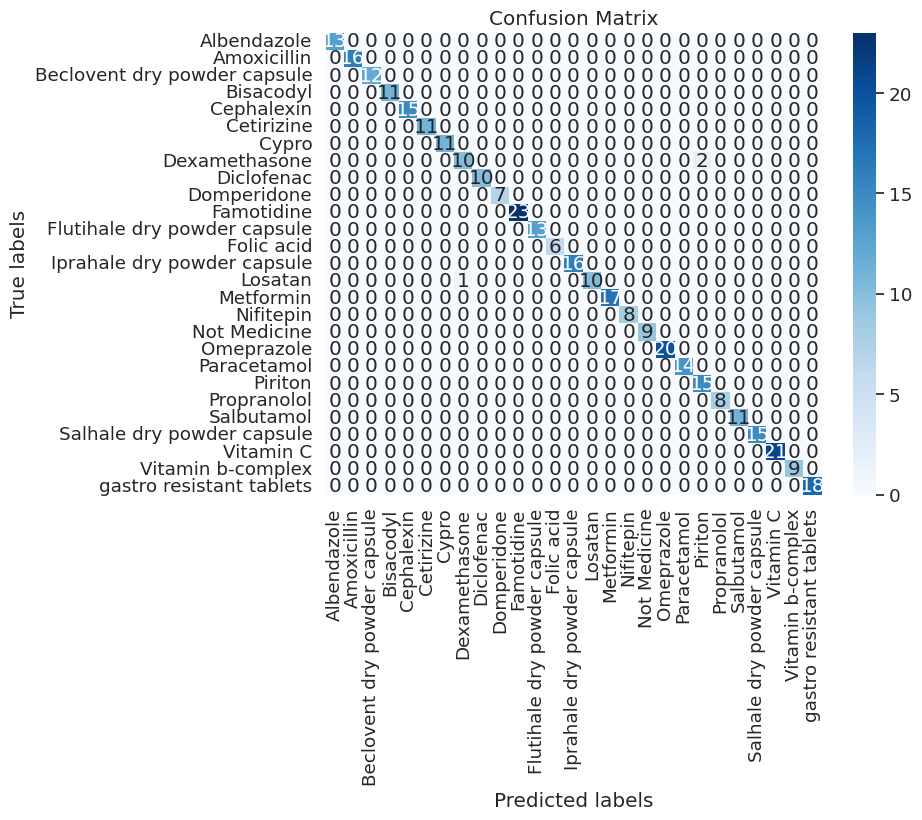

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with colors
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better visualization

# Create a heatmap with annotations and color bar
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=True,
            xticklabels=class_names, yticklabels=class_names)


plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


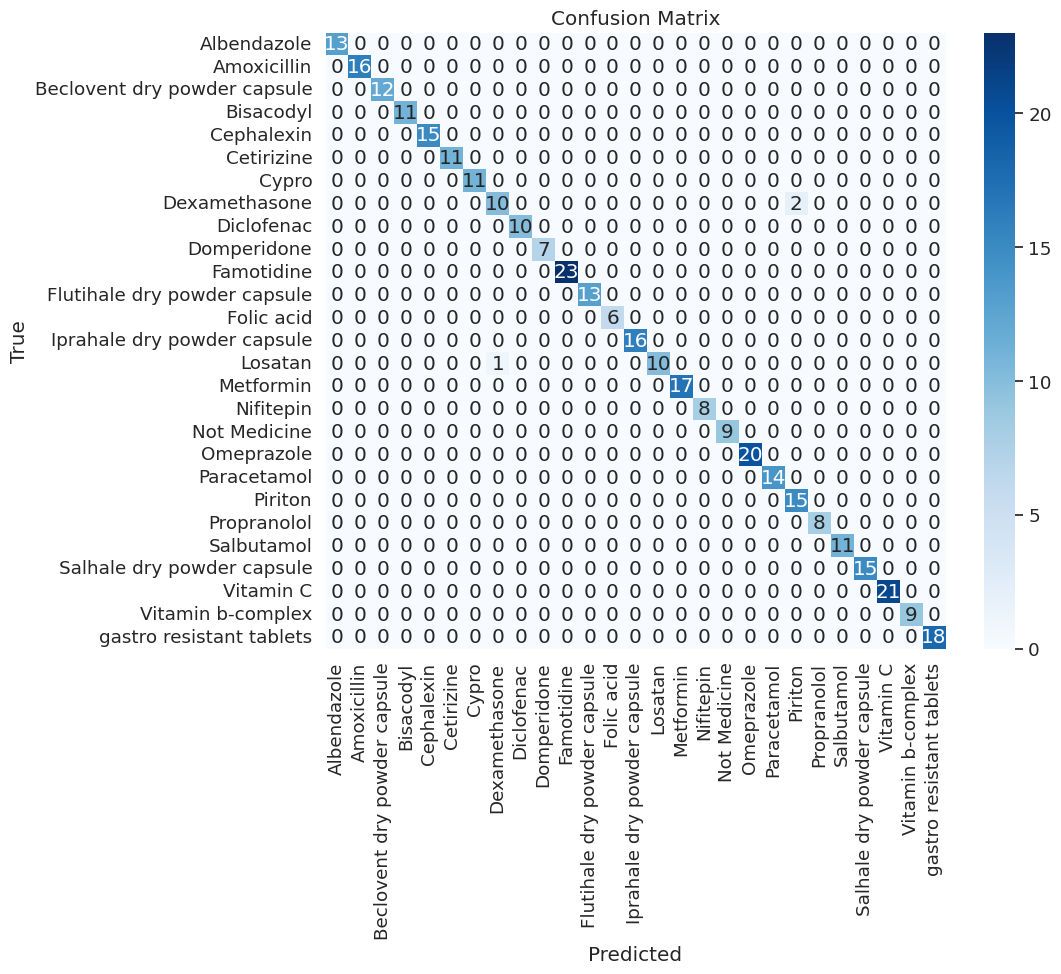

In [32]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# Print classification report
cr = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report")
print(cr)


Classification Report
                              precision    recall  f1-score   support

                 Albendazole       1.00      1.00      1.00        13
                 Amoxicillin       1.00      1.00      1.00        16
Beclovent dry powder capsule       1.00      1.00      1.00        12
                   Bisacodyl       1.00      1.00      1.00        11
                  Cephalexin       1.00      1.00      1.00        15
                  Cetirizine       1.00      1.00      1.00        11
                       Cypro       1.00      1.00      1.00        11
               Dexamethasone       0.91      0.83      0.87        12
                  Diclofenac       1.00      1.00      1.00        10
                 Domperidone       1.00      1.00      1.00         7
                  Famotidine       1.00      1.00      1.00        23
Flutihale dry powder capsule       1.00      1.00      1.00        13
                  Folic acid       1.00      1.00      1.00        

In [34]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

def calculate_metrics(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate classification report
    cr = classification_report(y_true, y_pred)

    # Calculate precision, recall, f1-score (weighted average)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return cm, cr, precision, recall, f1_score, accuracy

In [35]:
# Calculate metrics
cm, cr, precision, recall, f1_score, accuracy = calculate_metrics(y_true, y_pred)

# Print metrics
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)
print("Accuracy:", accuracy)

Confusion Matrix:
[[13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 1

In [36]:
# Save the model
model.save(f"/content/drive/MyDrive/CorrectModels/VGG16v1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
